In [75]:
import pandas as pd
import nltk
from nltk.corpus import stopwords 
from tqdm import tqdm
from collections import *
import operator
import geopandas
import matplotlib.pyplot as plt
import geoplot


businesses = pd.read_csv("businesses.csv", header=0)
reviews= pd.read_csv("reviews.csv", header= 0)

In [76]:
businesses.head()

,Unnamed: 0,advertiser,alias,appointment,attrs,categories_academic,categories_scrape,claimed,coordinates,display_phone,...,phone,price_academic,price_scrape,rating_academic,rating_scrape,related,review_count_academic,review_count_scrape,transactions,url
0,0,NaN,sleep-country-toronto,False,"{'Accepts Apple Pay': 'No', 'Bike Parking': 'Y...","[{'alias': 'mattresses', 'title': 'Mattresses'...","['Mattresses', 'Furniture Stores']",True,"{'latitude': 43.66205, 'longitude': -79.38597}",+1 416-642-1180,...,1.416642e+10,4,4.0,2.5,2.5,['/biz/roche-bobois-toronto?page_src=related_b...,3,3.0,[],https://www.yelp.com/biz/sleep-country-toronto...
1,1,NaN,pest-solution-services-toronto,False,NaN,"[{'alias': 'homecleaning', 'title': 'Home Clea...",['Pest Control'],False,"{'latitude': 43.7495489, 'longitude': -79.5807...",+1 416-451-7659,...,1.416452e+10,0,NaN,5.0,5.0,NaN,1,2.0,[],https://www.yelp.com/biz/pest-solution-service...
2,2,NaN,ccim-central-canada-toronto,False,NaN,"[{'alias': 'social_clubs', 'title': 'Social Cl...",['Social Clubs'],False,"{'latitude': 43.66528, 'longitude': -79.40358}",+1 416-244-0435,...,1.416244e+10,0,NaN,5.0,5.0,NaN,1,1.0,[],https://www.yelp.com/biz/ccim-central-canada-t...
3,3,NaN,happy-lemon-markham,False,"{'Take-out': 'Yes', 'Accepts Apple Pay': 'No',...","[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...","['Bubble Tea', 'Coffee & Tea']",True,"{'latitude': 43.8258200636421, 'longitude': -7...",+1 416-855-0768,...,1.416855e+10,1,1.0,3.5,3.5,['/biz/pop-up-house-markham?page_src=related_b...,32,33.0,[],https://www.yelp.com/biz/happy-lemon-markham?a...
4,4,NaN,finch-go-bus-terminal-toronto,False,NaN,"[{'alias': 'publictransport', 'title': 'Public...",['Public Transportation'],False,"{'latitude': 43.78268, 'longitude': -79.4158}",NaN,...,NaN,0,NaN,2.5,2.5,NaN,7,7.0,[],https://www.yelp.com/biz/finch-go-bus-terminal...


In [77]:
reviews.head()

,Unnamed: 0,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,review_count,review_date,review_id,review_language,review_text,ufc,user_id,user_loc,vote_count
0,0,bSQGCheX1BwvL67Az1OJlA,90,False,[],[],False,231.0,5.0,82,9/5/2018,NjYpdf2W7_2UU691w9Rlnw,en,I had a good experience at this store. I was g...,"[10, 1, 10]",q41qqkChL9fRxF43cnkgbw,"Houston, TX",11.0
1,1,bSQGCheX1BwvL67Az1OJlA,0,False,[],[],False,9.0,1.0,43,3/6/2018,G2hammYtHvmlAd19sbRRug,en,I reaaaaaally wish I had read all the stories ...,"[0, 0, 0]",tNT5I9-QcljS-7w_doXCXQ,"Toronto, Canada",0.0
2,2,bSQGCheX1BwvL67Az1OJlA,52,False,"[""Photo of Sleep Country - Toronto, ON, Canada...",['https://s3-media1.fl.yelpcdn.com/bphoto/E_gL...,False,27.0,1.0,31,7/30/2016,skBVzVCI4AZ0VCZKbSeFEA,en,Everything was fine until the delivery. I wait...,"[3, 1, 2]",9q1Do6TVM27RNHUQAQxPRg,"Toronto, Canada",3.0
3,3,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,3,12/16/2018,Bu6BZ8AQ2Rr3py6R_qKuWA,en,"Thought I had bed bugs, but it turned out to b...","[0, 0, 0]",cr-4gAf1_seYWLoO59Lp4w,"Old Toronto, Toronto, Canada",0.0
4,4,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,5,8/6/2014,deSmyPr4G1-sNlnGOTtx3w,en,"When we called, Mr. Akram was willing to come ...","[1, 0, 0]",CQkTIyhNczRlRI4kIdAzSw,"Toronto, Canada",1.0


In [78]:
id=[]
latitude=[]
longitude=[]


for x in range(businesses.shape[0]):
    if (businesses.iloc[x,8].split()[1].replace(',','')!= 'None' ):
        if (float(businesses.iloc[x,8].split()[1].replace(',',''))> 43 and float(businesses.iloc[x,8].split()[1].replace(',',''))<44):
            if(float(businesses.iloc[x,8].split()[3].replace('}',''))>-80 and float(businesses.iloc[x,8].split()[3].replace('}',''))<-79):
                latitude.append(float(businesses.iloc[x,8].split()[1].replace(',','')))
                longitude.append(float(businesses.iloc[x,8].split()[3].replace('}','')))
                id.append(businesses.iloc[x,13])




In [79]:
df = pd.DataFrame(
    {'Unique_id': id,
     'Latitude': latitude,
     'Longitude': longitude})


gdf = geopandas.GeoDataFrame(df, geometry= geopandas.points_from_xy(df.Longitude, df.Latitude))


df_neighbourhoods = geopandas.read_file("Neighbourhoods.geojson")



In [80]:
##Businesses DataFrame with associated Longitude and Latitude as a POINT object
gdf.head()

,Unique_id,Latitude,Longitude,geometry
0,bSQGCheX1BwvL67Az1OJlA,43.662050,-79.385970,POINT (-79.38597 43.66205)
1,Z7JV11GXw_RsGr8Ik_Hsag,43.749549,-79.580750,POINT (-79.5807504 43.7495489)
2,kI7ObOAe-Wvjdtnv-8Cu7w,43.665280,-79.403580,POINT (-79.40358000000001 43.66528)
3,Xo1LNzhnwE-ilqsM3ybs9Q,43.825820,-79.306346,POINT (-79.30634580552579 43.8258200636421)
4,83V1E_ePwuLMW5EI40fIBQ,43.782680,-79.415800,POINT (-79.4158 43.78268)


In [81]:
##Toronto Neighbourhood Dataframe
df_neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,1261,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,POLYGON ((-79.43591570873059 43.68015339477487...
1,1262,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,POLYGON ((-79.41095783825973 43.70408282301482...
2,1263,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,POLYGON ((-79.39119482591805 43.68108112277795...
3,1264,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,POLYGON ((-79.50528791818931 43.75987349878096...
4,1265,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.4396873322608 43.70560981891119,..."


In [82]:
##This code cell is a slight modification of the Vader Sentiment analysis tool found at :
##https://github.com/cjhutto/vaderSentiment


##Reference:
##Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

import os
import re
import math
import string
import requests
import json
from itertools import product
from inspect import getsourcefile
from io import open

# ##Constants##

# (empirically derived mean sentiment intensity rating increase for booster words)
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using ALLCAPs to emphasize a word)
C_INCR = 0.733
N_SCALAR = -0.74

# for removing punctuation
REGEX_REMOVE_PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation))

PUNC_LIST = [".", "!", "?", ",", ";", ":", "-", "'", "\"",
             "!!", "!!!", "??", "???", "?!?", "!?!", "?!?!", "!?!?"]
NEGATE = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
    {"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, "completely": B_INCR, "considerably": B_INCR,
     "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormously": B_INCR,
     "entirely": B_INCR, "especially": B_INCR, "exceptionally": B_INCR, "extremely": B_INCR,
     "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR,
     "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, "fucking": B_INCR,
     "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, "incredibly": B_INCR,
     "intensely": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
     "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
     "so": B_INCR, "substantially": B_INCR,
     "thoroughly": B_INCR, "totally": B_INCR, "tremendously": B_INCR,
     "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utterly": B_INCR,
     "very": B_INCR,
     "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
     "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
     "less": B_DECR, "little": B_DECR, "marginally": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
     "scarcely": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
     "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}

# check for sentiment laden idioms that do not contain lexicon words (future work, not yet implemented)
SENTIMENT_LADEN_IDIOMS = {"cut the mustard": 2, "hand to mouth": -2,
                          "back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                          "upper hand": 1, "break a leg": 2,
                          "cooking with gas": 2, "in the black": 2, "in the red": -2,
                          "on the ball": 2, "under the weather": -2}

# check for special case idioms containing lexicon words
SPECIAL_CASE_IDIOMS = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "yeah right": -2,
                       "kiss of death": -1.5}


# #Static methods# #

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    input_words = [str(w).lower() for w in input_words]
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i - 1] != "at":
            return True
    return False


def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score


def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if 0 < cap_differential < len(words):
        is_different = True
    return is_different


def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1
        # check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else:
                scalar -= C_INCR
    return scalar


class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text).encode('utf-8')
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from\
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)

    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = REGEX_REMOVE_PUNCTUATION.sub('', self.text)
        # removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()
        # remove singletons
        words_only = set(w for w in words_only if len(w) > 1)
        # the product gives ('cat', ',') and (',', 'cat')
        punc_before = {''.join(p): p[1] for p in product(PUNC_LIST, words_only)}
        punc_after = {''.join(p): p[0] for p in product(words_only, PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes


class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """

    def __init__(self, lexicon_file="vader_lexicon.txt", emoji_lexicon="emoji_utf8_lexicon.txt"):
        _this_module_file_path_ = os.path.abspath(getsourcefile(lambda: 0))
        lexicon_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), lexicon_file)
        with open(lexicon_full_filepath, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

        emoji_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), emoji_lexicon)
        with open(emoji_full_filepath, encoding='utf-8') as f:
            self.emoji_full_filepath = f.read()
        self.emojis = self.make_emoji_dict()

    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.split('\n'):
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict

    def make_emoji_dict(self):
        """
        Convert emoji lexicon file to a dictionary
        """
        emoji_dict = {}
        for line in self.emoji_full_filepath.split('\n'):
            (emoji, description) = line.strip().split('\t')[0:2]
            emoji_dict[emoji] = description
        return emoji_dict

    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """
        # convert emojis to their textual descriptions
        text_token_list = text.split()
        text_no_emoji_lst = []
        for token in text_token_list:
            if token in self.emojis:
                # get the textual description
                description = self.emojis[token]
                text_no_emoji_lst.append(description)
            else:
                text_no_emoji_lst.append(token)
        text = " ".join(x for x in text_no_emoji_lst)

        sentitext = SentiText(text)

        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            # check for vader_lexicon words that may be used as modifiers or negations
            if item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue
            if (i < len(words_and_emoticons) - 1 and item.lower() == "kind" and
                    words_and_emoticons[i + 1].lower() == "of"):
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)

        valence_dict = self.score_valence(sentiments, text)

        return valence_dict

    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            # get the sentiment valence
            valence = self.lexicon[item_lowercase]
            # check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR

            for start_i in range(0, 3):
                # dampen the scalar modifier of preceding words and emoticons
                # (excluding the ones that immediately preceed the item) based
                # on their distance from the current item.
                if i > start_i and words_and_emoticons[i - (start_i + 1)].lower() not in self.lexicon:
                    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._negation_check(valence, words_and_emoticons, start_i, i)
                    if start_i == 2:
                        valence = self._special_idioms_check(valence, words_and_emoticons, i)

            valence = self._least_check(valence, words_and_emoticons, i)
        sentiments.append(valence)
        return sentiments

    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if i > 1 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            if words_and_emoticons[i - 2].lower() != "at" and words_and_emoticons[i - 2].lower() != "very":
                valence = valence * N_SCALAR
        elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            valence = valence * N_SCALAR
        return valence

    @staticmethod
    def _but_check(words_and_emoticons, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if 'but' in words_and_emoticons_lower:
            bi = words_and_emoticons_lower.index('but')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 1.5)
        return sentiments

    @staticmethod
    def _special_idioms_check(valence, words_and_emoticons, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        onezero = "{0} {1}".format(words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoonezero = "{0} {1} {2}".format(words_and_emoticons_lower[i - 2],
                                          words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoone = "{0} {1}".format(words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwoone = "{0} {1} {2}".format(words_and_emoticons_lower[i - 3],
                                           words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwo = "{0} {1}".format(words_and_emoticons_lower[i - 3], words_and_emoticons_lower[i - 2])

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons_lower) - 1 > i:
            zeroone = "{0} {1}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1])
            if zeroone in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroone]
        if len(words_and_emoticons_lower) - 1 > i + 1:
            zeroonetwo = "{0} {1} {2}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1],
                                              words_and_emoticons_lower[i + 2])
            if zeroonetwo in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        n_grams = [threetwoone, threetwo, twoone]
        for n_gram in n_grams:
            if n_gram in BOOSTER_DICT:
                valence = valence + BOOSTER_DICT[n_gram]
        return valence

    @staticmethod
    def _sentiment_laden_idioms_check(valence, senti_text_lower):
        # Future Work
        # check for sentiment laden idioms that don't contain a lexicon word
        idioms_valences = []
        for idiom in SENTIMENT_LADEN_IDIOMS:
            if idiom in senti_text_lower:
                print(idiom, senti_text_lower)
                valence = SENTIMENT_LADEN_IDIOMS[idiom]
                idioms_valences.append(valence)
        if len(idioms_valences) > 0:
            valence = sum(idioms_valences) / float(len(idioms_valences))
        return valence

    @staticmethod
    def _negation_check(valence, words_and_emoticons, start_i, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if start_i == 0:
            if negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 1 word preceding lexicon word (w/o stopwords)
                valence = valence * N_SCALAR
        if start_i == 1:
            if words_and_emoticons_lower[i - 2] == "never" and \
                    (words_and_emoticons_lower[i - 1] == "so" or
                     words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 2] == "without" and \
                    words_and_emoticons_lower[i - 1] == "doubt":
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 2 words preceding the lexicon word position
                valence = valence * N_SCALAR
        if start_i == 2:
            if words_and_emoticons_lower[i - 3] == "never" and \
                    (words_and_emoticons_lower[i - 2] == "so" or words_and_emoticons_lower[i - 2] == "this") or \
                    (words_and_emoticons_lower[i - 1] == "so" or words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 3] == "without" and \
                    (words_and_emoticons_lower[i - 2] == "doubt" or words_and_emoticons_lower[i - 1] == "doubt"):
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 3 words preceding the lexicon word position
                valence = valence * N_SCALAR
        return valence

    def _punctuation_emphasis(self, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier
        return punct_emph_amplifier

    @staticmethod
    def _amplify_ep(text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count * 0.292
        return ep_amplifier

    @staticmethod
    def _amplify_qm(text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    @staticmethod
    def _sift_sentiment_scores(sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) + 1)  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) - 1)  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg": round(neg, 3),
             "neu": round(neu, 3),
             "pos": round(pos, 3),
             "compound": round(compound, 4)}

        return compound

In [84]:
##Create Dictionary to associate each business with their repsective score


if __name__ == '__main__':
    
    analyzer = SentimentIntensityAnalyzer()
    
##store_dict={BusinessID:Vader Sentiments score from Yelp Reviews Data}
    store_dict={}

        
    for i in range(reviews.shape[0]):
        counter = 0;
        if (isinstance(reviews.iloc[i][13], str)):
            x= reviews.iloc[i][13].split(". ")
            for sentence in x:
                vs = analyzer.polarity_scores(sentence)
                counter+=vs;
            final_score= counter/ len(x)
            store_dict[reviews.iloc[i][1]]= round(final_score,4)

In [86]:
scores=[]
reviews=[]


for i in range(df_neighbourhoods.shape[0]):
    counter=0
    cc=0
    for j in range(gdf.shape[0]):
        if (gdf.iloc[j,3].within(df_neighbourhoods.loc[i,'geometry']) and gdf.iloc[j,0] in score_dict):
            counter+= score_dict[gdf.iloc[j,0]]
            cc+=1
    scores.append(counter/cc)
    reviews.append(cc)

In [87]:
df_neighbourhoods['Score'] = scores
df_neighbourhoods['Reviews'] = reviews


In [88]:
df_neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry,Score,Reviews
0,1261,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,POLYGON ((-79.43591570873059 43.68015339477487...,0.233483,183
1,1262,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,POLYGON ((-79.41095783825973 43.70408282301482...,0.201831,260
2,1263,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,POLYGON ((-79.39119482591805 43.68108112277795...,0.209897,126
3,1264,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,POLYGON ((-79.50528791818931 43.75987349878096...,0.176795,624
4,1265,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.4396873322608 43.70560981891119,...",0.171206,525


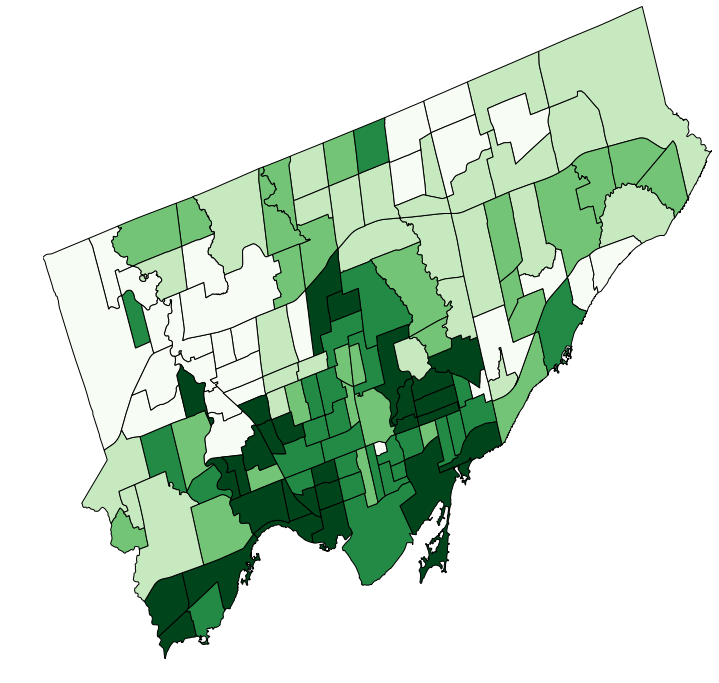

In [89]:
##From graph,lighter areas= lower score(negative sentiment) and darker areas= higher score(positive sentiment)

geoplot.choropleth(df_neighbourhoods, hue='Score', cmap='Greens', figsize=(12,12))